# Community Detection in FriendFeed Network

This notebook focuses on detecting communities within the FriendFeed social network. We'll use the preprocessed datasets to build a graph and analyze community structures.

## 1. Import Libraries and Load Data

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from networkx.algorithms import community
from community import community_louvain
import random
import matplotlib.pyplot as plt

%matplotlib inline
sns.set(style='whitegrid')

In [2]:
# Load preprocessed data
users = pd.read_parquet('processed_data/users_cleaned.parquet')
subs = pd.read_parquet('processed_data/subs_cleaned.parquet')
following = pd.read_parquet('processed_data/following_cleaned.parquet')
comments = pd.read_parquet('processed_data/comments_cleaned.parquet')
likes = pd.read_parquet('processed_data/likes_cleaned.parquet')
entries = pd.read_parquet('processed_data/entries_cleaned.parquet')

In [3]:
# Get the unique user IDs from both dataframes
user_ids_in_likes = set(likes['userID'].unique())
user_ids_in_users = set(users['ID'].unique())

# Find user IDs in likes but not in users
user_ids_not_in_users = user_ids_in_likes - user_ids_in_users

# Display the result
print(f"Number of user IDs in 'likes' but not in 'users': {len(user_ids_not_in_users)}")
if len(user_ids_not_in_users) > 0:
    print(f"Sample of user IDs not in users: {list(user_ids_not_in_users)[:10]}")


Number of user IDs in 'likes' but not in 'users': 0


In [4]:
# Get the unique user IDs from both dataframes
user_ids_in_likes = set(entries['PostedBy'].unique())
user_ids_in_users = set(users['ID'].unique())

# Find user IDs in likes but not in users
user_ids_not_in_users = user_ids_in_likes - user_ids_in_users

# Display the result
print(f"Number of user IDs in 'likes' but not in 'users': {len(user_ids_not_in_users)}")
if len(user_ids_not_in_users) > 0:
    print(f"Sample of user IDs not in users: {list(user_ids_not_in_users)[:10]}")


Number of user IDs in 'likes' but not in 'users': 0


In [5]:
# sizes of each dataframe
print('users:', users.shape)
print('subs:', subs.shape)
print('following:', following.shape)
print('comments:', comments.shape)
print('likes:', likes.shape)
print('entries:', entries.shape)

users: (645414, 4)
subs: (24761879, 2)
following: (18477145, 3)
comments: (2623974, 6)
likes: (370687, 3)
entries: (10954103, 5)


In [6]:
# length of unique users
print('df: users')
print(users.columns)
print('unique users:', len(users['ID'].unique()))
print('----------------------------\n')

print('df: subs')
print(subs.columns)
print('unique subs:', len(subs['FollowerID'].unique()))
print('unique subs:', len(subs['FollowedID'].unique()))
print('----------------------------\n')

print('df: following')
print(following.columns)
print('unique following:', len(following['FollowerID'].unique()))
print('unique following:', len(following['FollowedID'].unique()))
print('----------------------------\n')

print('df: comments')
print(comments.columns)
print('unique comments:', len(comments['PostedBy'].unique()))
print('----------------------------\n')

print('df: likes')
print(likes.columns)
print('unique likes:', len(likes['userID'].unique()))
print('----------------------------\n')

print('df: entries')
print(entries.columns)
print('unique entries:', len(entries['PostedBy'].unique()))

df: users
Index(['ID', 'Type', 'Name', 'Description'], dtype='object')
unique users: 645414
----------------------------

df: subs
Index(['FollowerID', 'FollowedID'], dtype='object')
unique subs: 525824
unique subs: 527108
----------------------------

df: following
Index(['FollowerID', 'FollowedID', 'Timestamp'], dtype='object')
unique following: 196436
unique following: 443552
----------------------------

df: comments
Index(['PostID', 'EntryID', 'PostedBy', 'SourceURL', 'Timestamp', 'Text'], dtype='object')
unique comments: 40585
----------------------------

df: likes
Index(['userID', 'PostID', 'Timestamp'], dtype='object')
unique likes: 12935
----------------------------

df: entries
Index(['PostID', 'PostedBy', 'SourceURL', 'Timestamp', 'Text'], dtype='object')
unique entries: 209716


## 2. Build the Network Graph

We'll create a directed graph where nodes represent users, and edges represent different types of interactions such as follows, likes, and comments.

In [8]:
# Initialize directed graph
G = nx.DiGraph()

# Add nodes for users
G.add_nodes_from(users['ID'])

# Display basic graph information
print(f"Graph has {G.number_of_nodes()}")

Graph has 645414


###  Adding edges based on following

In [9]:
%%time
# Add edges for followers (from the 'subs' DataFrame)
edges = [(row['FollowerID'], row['FollowedID']) for _, row in following.iterrows()]

# Add edges to the graph
G.add_edges_from(edges, relationship='following')

# Display basic graph information after adding edges
print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")


Graph has 645414 nodes and 18477145 edges
CPU times: user 8min 36s, sys: 6.09 s, total: 8min 42s
Wall time: 8min 42s


###  Adding edges based on subs

In [10]:
%%time
# Add edges for followers (from the 'subs' DataFrame)
edges = [(row['FollowerID'], row['FollowedID']) for _, row in subs.iterrows()]

# Add edges to the graph
G.add_edges_from(edges, relationship='subs')

# Display basic graph information after adding edges
print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

Graph has 645414 nodes and 39380139 edges
CPU times: user 11min 16s, sys: 4.95 s, total: 11min 21s
Wall time: 11min 21s


###  Adding edges based on likes

In [11]:
%%time
# Step 1: Create a mapping of PostID to the user who owns the post (from the 'entries' DataFrame)
post_owner_mapping = dict(zip(entries['PostID'], entries['PostedBy']))

# Step 2: Add edges for likes (from the 'likes' DataFrame)
edges_likes = []

for _, row in likes.iterrows():
    user_id = row['userID']        # User who liked the post
    post_id = row['PostID']        # Post that was liked
    
    # Find the owner of the post
    if post_id in post_owner_mapping:
        post_owner = post_owner_mapping[post_id]
        # Add an edge from the user who liked the post to the owner of the post
        edges_likes.append((user_id, post_owner))

# Add the edges to the graph
G.add_edges_from(edges_likes, relationship='like')

# Display basic graph information after adding edges
print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

Graph has 645414 nodes and 39431538 edges
CPU times: user 16.3 s, sys: 337 ms, total: 16.6 s
Wall time: 16.5 s


###  Adding edges based on comment

In [12]:
%%time
# Step 1: Create a mapping of EntryID (PostID in comments) to the user who owns the post (from the 'entries' DataFrame)
post_author_mapping = dict(zip(entries['PostID'], entries['PostedBy']))

# Step 2: Add edges for comments (from the 'comments' DataFrame)
edges_comments = []

for _, row in comments.iterrows():
    commenter = row['PostedBy']    # The user who made the comment
    entry_id = row['EntryID']      # The post (EntryID) on which the comment was made
    
    # Find the author of the post (EntryID)
    if entry_id in post_author_mapping:
        post_author = post_author_mapping[entry_id]
        # Add an edge from the commenter to the author of the post they commented on
        edges_comments.append((commenter, post_author))

# Add the edges to the graph
G.add_edges_from(edges_comments, relationship='comment')

# Display updated graph information
print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

Graph has 645414 nodes and 39562155 edges
CPU times: user 1min 22s, sys: 827 ms, total: 1min 23s
Wall time: 1min 23s


### Plot samples from the network

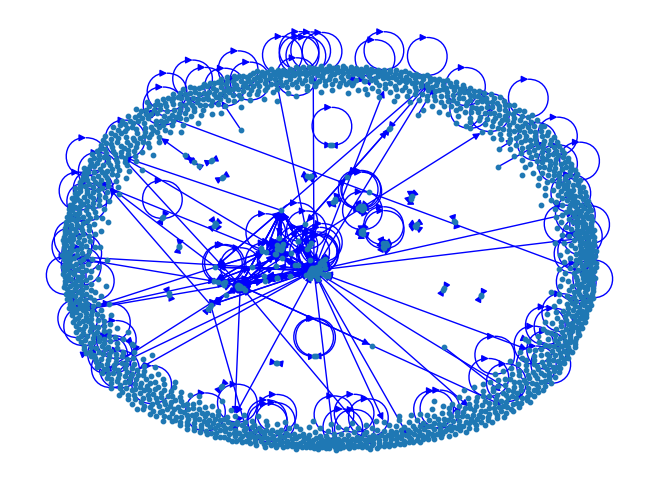

In [18]:
import networkx as nx
import random
import matplotlib.pyplot as plt

# Step 1: Specify the number of nodes to sample
num_nodes_to_sample = 2000  # Set your desired number of nodes

# Ensure that the sample size is not greater than the number of nodes in the graph
num_nodes_to_sample = min(num_nodes_to_sample, G.number_of_nodes())

# Convert G.nodes() to a list so it can be sampled
sampled_nodes = random.sample(list(G.nodes()), num_nodes_to_sample)

# Step 2: Create a subgraph from the sampled nodes
# The subgraph will include all edges between the sampled nodes
G_sampled = G.subgraph(sampled_nodes).copy()

# Step 3: Plot the sampled subgraph
# plt.figure(figsize=(10, 10))  # Set the plot size
nx.draw(G_sampled, node_size=10, edge_color='blue', with_labels=False)

# Display the plot
plt.show()


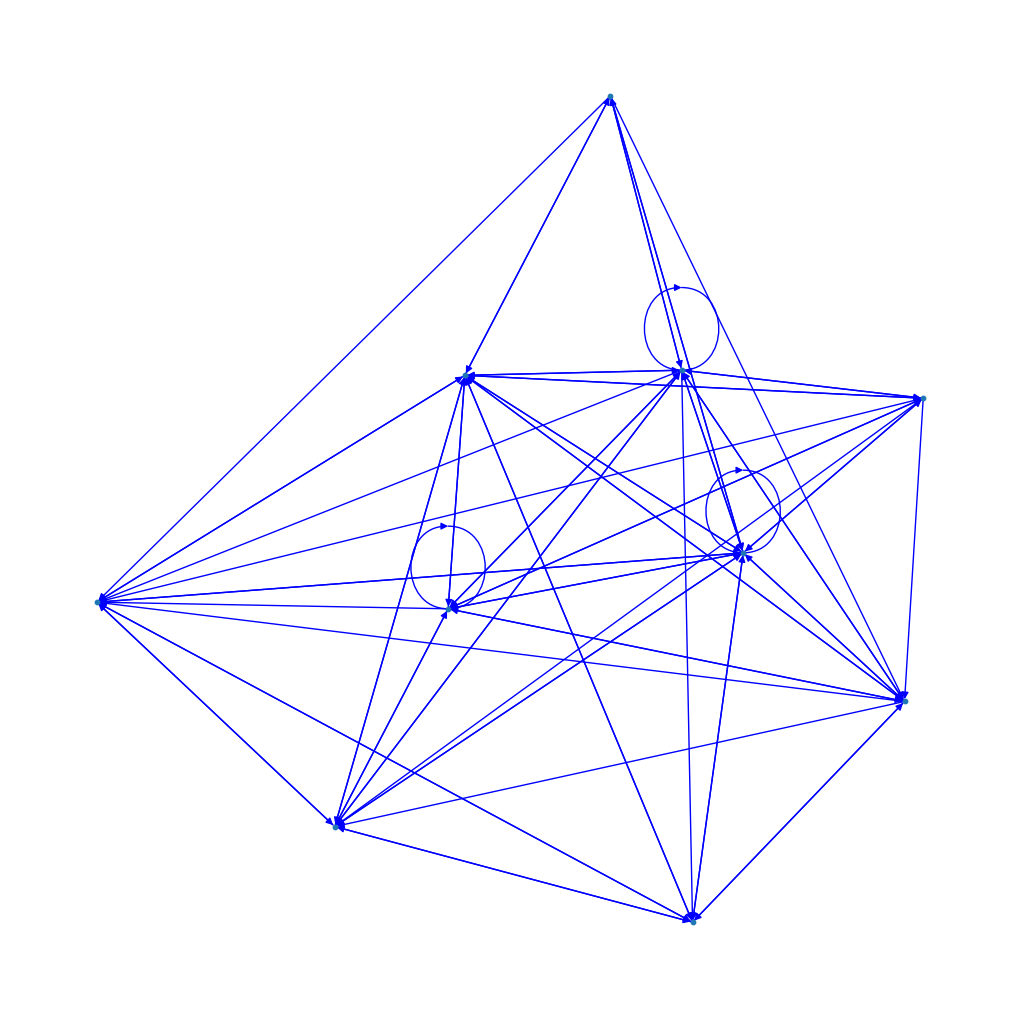

In [25]:
import networkx as nx
import matplotlib.pyplot as plt

# Step 1: Specify the number of nodes to sample based on the most connections (highest degree)
num_nodes_to_sample = 10  # Set your desired number of nodes

# Get the degrees of all nodes (degree is the number of edges connected to a node)
node_degrees = dict(G.degree())

# Sort nodes by degree in descending order and select the top ones
sampled_nodes = sorted(node_degrees, key=node_degrees.get, reverse=True)[:num_nodes_to_sample]

# Step 2: Create a subgraph from the sampled nodes
# The subgraph will include all edges between the sampled nodes
G_sampled = G.subgraph(sampled_nodes).copy()

# Step 3: Plot the sampled subgraph
plt.figure(figsize=(10, 10))  # Set the plot size
nx.draw(G_sampled, node_size=10, edge_color='blue', with_labels=False)

# Display the plot
plt.show()


## Savle the network

In [ ]:
# Save the graph as a GraphML file
nx.write_graphml(G, "graph.graphml")


## 3. Analyze Network Structure

Let's examine the basic characteristics of the network, such as degree distributions.

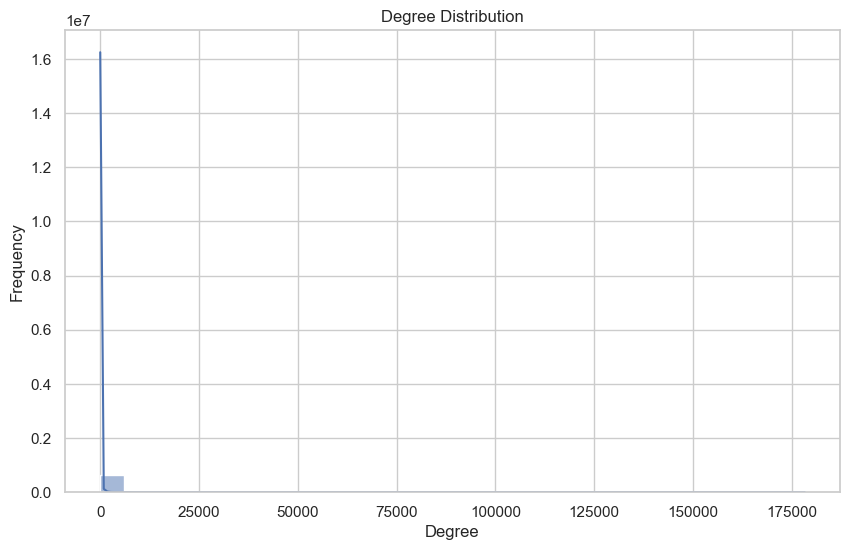

In [19]:
# Calculate degree distributions
degrees = dict(G.degree())
in_degrees = dict(G.in_degree())
out_degrees = dict(G.out_degree())

# Plot degree distribution
plt.figure(figsize=(10, 6))
sns.histplot(list(degrees.values()), bins=30, kde=True)
plt.title('Degree Distribution')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.show()

## 4. Detect Communities Using the Louvain Method

The Louvain algorithm is a popular method for community detection in large networks. We'll use this method to detect communities and analyze them.

In [20]:
%%time
# Convert graph to undirected for community detection
G_undirected = G.to_undirected()

# Apply Louvain method for community detection
partition = community_louvain.best_partition(G_undirected)
communities = set(partition.values())
num_communities = len(communities)

print(f"Number of communities detected: {num_communities}")

# Add community information as node attribute
nx.set_node_attributes(G, partition, 'community')

KeyboardInterrupt: 

## 5. Visualize Communities

Let's visualize the detected communities. Each node will be colored based on the community it belongs to.

In [ ]:
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G_undirected, k=0.1)

# Draw nodes with colors according to community
colors = [partition[node] for node in G_undirected.nodes]
nx.draw_networkx_nodes(G_undirected, pos, node_color=colors, cmap=plt.cm.jet, node_size=20)

# Draw edges
nx.draw_networkx_edges(G_undirected, pos, alpha=0.1)

plt.title('Community Detection using Louvain Method')
plt.axis('off')
plt.show()

## 6. Community Analysis

We can further analyze the communities to understand their sizes and characteristics.

In [ ]:
# Calculate size of each community
community_sizes = pd.Series(list(partition.values())).value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=community_sizes.index, y=community_sizes.values, palette='viridis')
plt.title('Community Size Distribution')
plt.xlabel('Community ID')
plt.ylabel('Number of Nodes')
plt.show()

## 7. Save the Results

Finally, let's save the graph with community information for further analysis if needed.

In [ ]:
# Save graph with community info
nx.write_gexf(G, 'friendfeed_community_graph.gexf')
print("Graph with community information saved as 'friendfeed_community_graph.gexf'.")